___

<a href='http://www.dourthe.tech'> <img src='Dourthe_Technologies_Headers.png' /></a>
___
<center><em>For more information, visit <a href='http://www.dourthe.tech'>www.dourthe.tech</a></em></center>

# Coronary Heart Disease Risk Prediction using Support Vector Machine

___ 
## Objective
Train a Support Vector Machine classifier to predict the risk of developing coronary heart disease within 10 years using data from the Framingham Heart Study.

 ___
## Dataset
The Framingham Heart Study (FHS) is an epidemiologic study begun in Framingham in 1948 with 5,209 men and women. Since that time the FHS has studied three generations of participants resulting in biological specimens and data from nearly 15,000 participants. This clinically and genetically well-characterized population is a valuable scientific source that is maintained under the joint stewardship of Boston University and the NHLBI. Since 1994, two groups from minority populations, including related individuals have been added to the FHS.

The dataset can be found at: https://www.kaggle.com/amanajmera1/framingham-heart-study-dataset/data

For more information on the Framingham Heart Study, please visit: https://framinghamheartstudy.org/fhs-for-researchers/data-available-overview/

The corresponding CSV file named _framingham.csv_ contains the following columns:

| Name | Description | Data Type | 
|:---|:---|:---|
| male | 0 = Female; 1 = Male | _integer_ |
| age | age at exam time | _integer_ |
| education | 1 = Some High School; 2 = High School or GED; 3 = Some College or Vocational School; 4 = college | _float_ |
| currentSmoker | 0 = nonsmoker; 1 = smoker | _integer_ |
| cigsPerDay | number of cigarettes smoked per day (estimated average) | _float_ |
| BPMeds | 0 = not on Blood Pressure medications; 1 = on Blood Pressure medications | _float_ |
| prevalentStroke | history of stroke: 0 = No; 1 = Yes | _integer_ |
| prevalentHyp | history of hypertension: 0 = No; 1 = Yes | _integer_ |
| diabetes | 0 = No; 1 = Yes | _integer_ |
| totChol | cholesterol level in mg/dL | _float_ |
| sysBP | systolic Blood Pressure in mmHg | _float_ |
| diaBP | diastolic Blood Pressure in mmHg | _float_ |
| BMI | Body Mass Index calculated as: Weight (kg) / Height(meter-squared) | _float_ |
| heartRate | heart rate in beats/min (ventricular) | _float_ |
| glucose | glucose level in mg/dL | _float_ |
| TenYearCHD | 10-year risk of developing coronary heart disease: 0 = No; 1 = Yes | _integer_ |

___
## Libraries Imports
### Data manipulation and analysis

In [1]:
import pandas as pd
import numpy as np

### Data visualization

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from jupyterthemes import jtplot
jtplot.style(theme='chesterish')

### Machine learning

In [3]:
# Create new synthetic points in an unbalanced dataset using the Synthetic Minority Over-sampling Technique (SMOTE)
from imblearn.over_sampling import SMOTE

# Split data between training and test set
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

# Data scaling
from sklearn.preprocessing import MinMaxScaler

# Create a pipeline for imbalanced datasets
from imblearn.pipeline import make_pipeline

# Support vector machine classifier
from sklearn.svm import SVC

# Cross-validation
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Model evaluation
from sklearn.metrics import classification_report, confusion_matrix, average_precision_score, precision_recall_curve
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score

___
## Data Import

In [4]:
df = pd.read_csv('framingham.csv')

___
## Exploratory Data Analysis
### General

**Display the first few rows of the dataset.**

In [5]:
df.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


### Missing data
**Check for missing data (expressed as a percentage of the dataset length).**

In [6]:
df.isnull().sum()*100/len(df)

male               0.000000
age                0.000000
education          2.476415
currentSmoker      0.000000
cigsPerDay         0.683962
BPMeds             1.250000
prevalentStroke    0.000000
prevalentHyp       0.000000
diabetes           0.000000
totChol            1.179245
sysBP              0.000000
diaBP              0.000000
BMI                0.448113
heartRate          0.023585
glucose            9.150943
TenYearCHD         0.000000
dtype: float64

**Thankfully, there are not too many missing data.**

Most of the variables that have missing observations are missing less than 3% of the total data length, which can easily be dropped.

**However, the _glucose_ column is still missing close to 10%, so let's see if we can estimate those missing values.**

Let's start by looking at the correlation matrix and see if any correlation pop up.

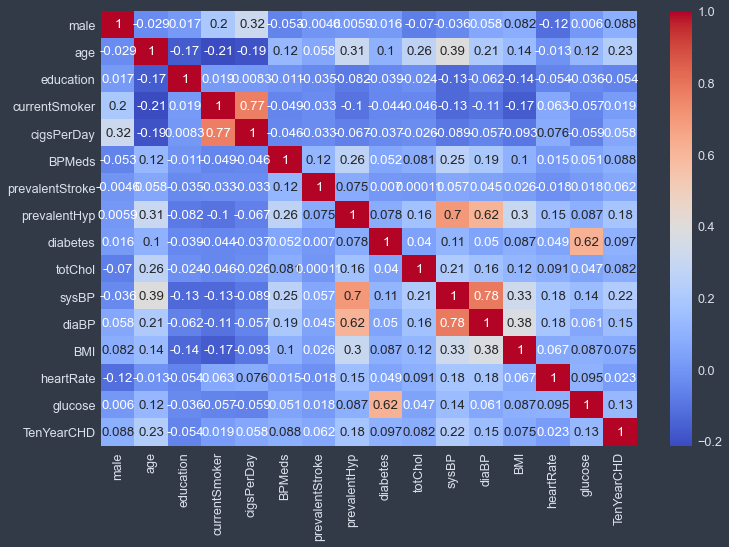

In [7]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), cmap='coolwarm', annot=True)
plt.show()

We see a moderate correlation between _glucose_ and _diabetes_ which makes sense.

**Let's take a closer look by focusing on the correlation between the _glucose_ column and the rest of the data.**

In [8]:
glucose_corr = df.corr()['glucose'].sort_values()[:-1]

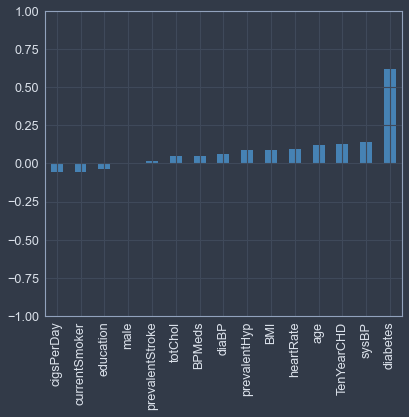

In [9]:
glucose_corr.plot(kind='bar', color='steelblue')
plt.ylim(-1,1)
plt.show()

The correlation between diabetes and glucose seem strong enough to try and fill the missing _glucose_ values using the information from the _diabetes_ and _glucose_ columns.

**We can start by looking at the average _glucose_ values for people with and without diabetes.**

In [10]:
df.groupby('diabetes').describe()['glucose']

,count,mean,std,min,25%,50%,75%,max
diabetes,,,,,,,,
0,3747.0,79.487323,12.957198,40.0,71.0,78.0,86.0,163.0
1,105.0,170.333333,84.232242,47.0,110.0,145.0,215.0,394.0


This table shows that most of the population does not have diabetes.

It also shows that the standard deviation of the glucose level in people with diabetes is quite high, which means that it would not make sense to fill in missing _glucose_ values using the overall mean _glucose_ value for people with diabetes. However, since the standard deviation of the _glucose_ levels in the population with no diabetes is smaller, we could try to fill in the missing _glucose_ values of this group using this mean assessment.

**Let's see how many missing data we have for each group:**

In [11]:
df[df['glucose'].isna()].groupby('diabetes').describe()['male']

,count,mean,std,min,25%,50%,75%,max
diabetes,,,,,,,,
0,384.0,0.296875,0.457477,0.0,0.0,0.0,1.00,1.0
1,4.0,0.250000,0.500000,0.0,0.0,0.0,0.25,1.0


Since most of the missing _glucose_ values are for people that don't have diabetes (which could have been expected as people with diabetes have to measure their glucose levels more frequently), let's fill in those missing values using the mean _glucose_ level reported across the non-diabetic group.

**We can start by isolating the mean _glucose_ level of the population with no diabetes:**

In [12]:
mean_glucose_no_d = df.groupby('diabetes').mean()['glucose'][0]
print('Mean glucose level for non-diabetic people:\t', np.round(mean_glucose_no_d, 2), ' mg/dL')

Mean glucose level for non-diabetic people:	 79.49  mg/dL


**We can now create a function that replaces all missing _glucose_ values by the mean calculated above and apply that function to the corresponding column.**

In [13]:
def fill_glucose_nan(glucose):    
    if np.isnan(glucose):
        return mean_glucose_no_d
    else:
        return glucose

In [14]:
df['glucose'] = df['glucose'].apply(fill_glucose_nan)

**Let's heck for missing values again:**

In [15]:
df.isnull().sum()*100/len(df)

male               0.000000
age                0.000000
education          2.476415
currentSmoker      0.000000
cigsPerDay         0.683962
BPMeds             1.250000
prevalentStroke    0.000000
prevalentHyp       0.000000
diabetes           0.000000
totChol            1.179245
sysBP              0.000000
diaBP              0.000000
BMI                0.448113
heartRate          0.023585
glucose            0.000000
TenYearCHD         0.000000
dtype: float64

**Now that the glucose column has been filled, we can simply drop the rows with remaining missing data and calculate the corresponding percentage of dropped data:**

In [16]:
original_length = len(df)

In [17]:
df = df.dropna()

In [18]:
print('Percentage of dropped data:\t', np.round(100-len(df)*100/original_length, 2), ' %')

Percentage of dropped data:	 5.92  %


**Let's have a final check to make sure that there are no remaining missing observations in our dataset:**

In [19]:
df.isnull().sum().max()

0

### Data visualization

**We can start by checking if the dataset is balanced (i.e. comparable counts for the no-risk and 10-year-CHD-risk groups).**

c:\users\bdour\anaconda3\envs\python-3-6\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


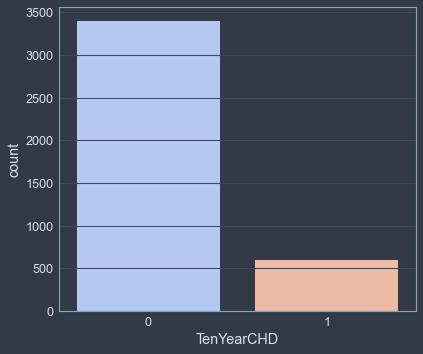

In [20]:
sns.countplot('TenYearCHD', data=df, palette='coolwarm')
plt.show()

In this case, the dataset is clearly unbalanced, which was to be expected as most health-related datasets have usually less cases for the disease condition (thankfully!).

**Let's look at a few variables and their distribution based on the _TenYearCHD_ column.**

c:\users\bdour\anaconda3\envs\python-3-6\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\bdour\anaconda3\envs\python-3-6\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


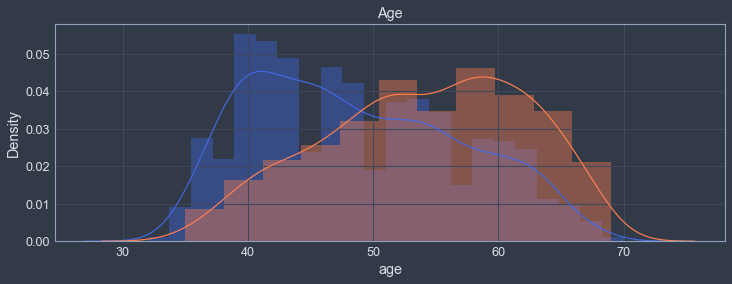

In [21]:
plt.figure(figsize=(12,4))
sns.distplot(df[df['TenYearCHD']==0]['age'], color='royalblue')
sns.distplot(df[df['TenYearCHD']==1]['age'], color='coral')
plt.title('Age')
plt.show()

c:\users\bdour\anaconda3\envs\python-3-6\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\bdour\anaconda3\envs\python-3-6\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


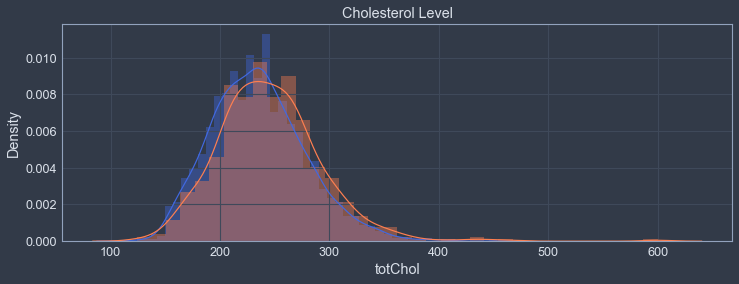

In [22]:
plt.figure(figsize=(12,4))
sns.distplot(df[df['TenYearCHD']==0]['totChol'], color='royalblue')
sns.distplot(df[df['TenYearCHD']==1]['totChol'], color='coral')
plt.title('Cholesterol Level')
plt.show()

c:\users\bdour\anaconda3\envs\python-3-6\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\bdour\anaconda3\envs\python-3-6\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\bdour\anaconda3\envs\python-3-6\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with

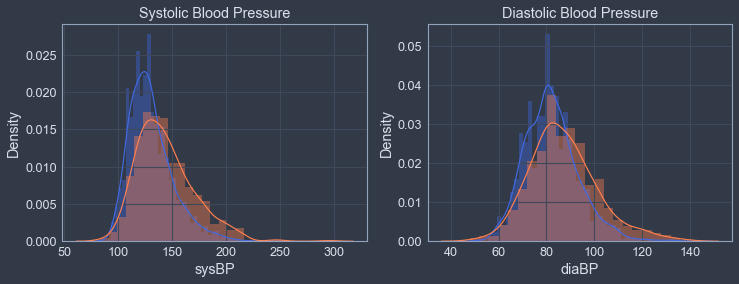

In [23]:
plt.figure(figsize=(12,4))
plt.subplot(121)
sns.distplot(df[df['TenYearCHD']==0]['sysBP'], color='royalblue')
sns.distplot(df[df['TenYearCHD']==1]['sysBP'], color='coral')
plt.title('Systolic Blood Pressure')
plt.subplot(122)
sns.distplot(df[df['TenYearCHD']==0]['diaBP'], color='royalblue')
sns.distplot(df[df['TenYearCHD']==1]['diaBP'], color='coral')
plt.title('Diastolic Blood Pressure')
plt.show()

c:\users\bdour\anaconda3\envs\python-3-6\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\bdour\anaconda3\envs\python-3-6\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


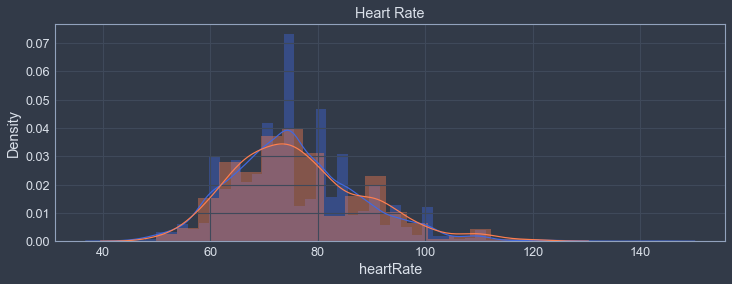

In [24]:
plt.figure(figsize=(12,4))
sns.distplot(df[df['TenYearCHD']==0]['heartRate'], color='royalblue')
sns.distplot(df[df['TenYearCHD']==1]['heartRate'], color='coral')
plt.title('Heart Rate')
plt.show()

c:\users\bdour\anaconda3\envs\python-3-6\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\bdour\anaconda3\envs\python-3-6\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


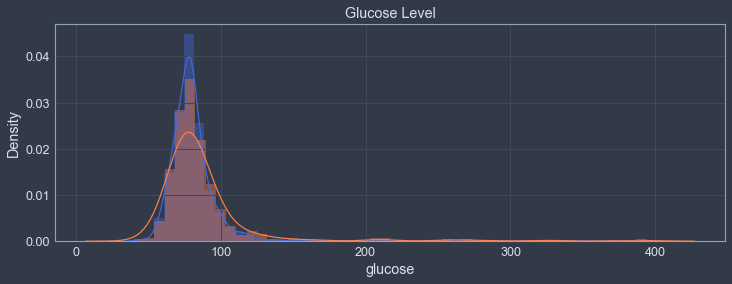

In [25]:
plt.figure(figsize=(12,4))
sns.distplot(df[df['TenYearCHD']==0]['glucose'], color='royalblue')
sns.distplot(df[df['TenYearCHD']==1]['glucose'], color='coral')
plt.title('Glucose Level')
plt.show()

**CONCLUSION**

Aside from the _age_ column, it seems hard to find one metric that can clearly distinguish between groups.

___
## Model 1 - Dataset imbalance ignored
**We will start by defining and training a model without accounting for the imbalance of the dataset.**
### Input/Output definition

In [26]:
X = df.drop('TenYearCHD', axis=1)
y = df['TenYearCHD']

### Train/Test split
**Perform usual train/test split with defined test_size.**

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

**Compare original label distribution to train/test split label distribution.**

In [28]:
_, original_labels_count = np.unique(y, return_counts=True)
original_dist = np.round(original_labels_count/len(y)*100, 2)
_, train_labels_count = np.unique(y_train, return_counts=True)
train_dist = np.round(train_labels_count/len(y_train)*100, 2)
_, test_labels_count = np.unique(y_test, return_counts=True)
test_dist = np.round(test_labels_count/len(y_test)*100, 2)

print('LABELS DISTRIBUTION')
print('\tOriginal:\t\t', original_dist[0], '% (label 0)\t', original_dist[1], '% (label 1)')
print('\tTraining set:\t\t', train_dist[0], '% (label 0)\t', train_dist[1], '% (label 1)')
print('\tTest set:\t\t', test_dist[0], '% (label 0)\t', test_dist[1], '% (label 1)')

LABELS DISTRIBUTION
	Original:		 85.08 % (label 0)	 14.92 % (label 1)
	Training set:		 85.28 % (label 0)	 14.72 % (label 1)
	Test set:		 84.63 % (label 0)	 15.37 % (label 1)


### Data scaling
**To prevent the potential impact of higher weights from variables that have larger ranges of values, we need to scale the data.**

We can start by defining a scaler and fitting it to the training data.

_Warning: do not fit the scaler to the test data, as in a real life scenario we would not be able to fit the scaler to the testing data._

In [29]:
scaler = MinMaxScaler()

In [30]:
scaler.fit(X_train)

MinMaxScaler()

**Now, we can transform the training and test data.**

Note: no need to transform the label data.

In [31]:
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Define and fit model to training data
**First, we need to define a grid of parameters that will be used during cross-validation.**

In [32]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [1,0.1,0.01,0.001,0.0001],
              'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}

**Now, we can define an instance of GridSearchCV using SVC as the estimator.**

In [33]:
grid_SVC = GridSearchCV(SVC(), param_grid, refit=True)

In [34]:
grid_SVC.fit(X_train_scaled, y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'poly', 'sigmoid', 'linear']})

### Model evaluation

**Generate predictions:**

In [35]:
predictions = grid_SVC.predict(X_test_scaled)

**Evaluate the model using classification report and confusion matrix:**

In [36]:
cm = confusion_matrix(y_test, predictions)
print('CONFUSION MATRIX\n')
print('Total number of')
print('\tTrue positives:\t\t', cm[1,1])
print('\tTrue negatives:\t\t', cm[0,0])
print('\tFalse positives:\t', cm[0,1], '\t\tType I error')
print('\tFalse negatives:\t', cm[1,0], '\t\tType II error')
print('\n')
print('Correct classifications:\t', np.round(100*(cm[0,0]+cm[1,1])/len(X_test),2), '%')
print('Incorrect classifications:\t', np.round(100*(cm[1,0]+cm[0,1])/len(X_test),2), '%')
print('\nCLASSIFICATION REPORT\n')
print(classification_report(y_test, predictions))

CONFUSION MATRIX

Total number of
	True positives:		 12
	True negatives:		 1004
	False positives:	 9 		Type I error
	False negatives:	 172 		Type II error


Correct classifications:	 84.88 %
Incorrect classifications:	 15.12 %

CLASSIFICATION REPORT

              precision    recall  f1-score   support

           0       0.85      0.99      0.92      1013
           1       0.57      0.07      0.12       184

    accuracy                           0.85      1197
   macro avg       0.71      0.53      0.52      1197
weighted avg       0.81      0.85      0.79      1197



**INTERPRETATION**

First, it should be noted that since this dataset is unbalanced, an accuracy of 86% is not a good performance indicator. Indeed, since about 85% of the data belongs to the no-risk group, an algorithm that simply classifies everyone as a no-risk for CHD would always have an accuracy of 85%.

Altogether, without accounting for the imbalance of the dataset, the model performed poorly in terms of recall score on the under-represented label.

We can also see a large number of False Negatives. Consedering that we are dealing with health data, False Positives would be preferable as we would rather predict that a person is at-risk of CHD and use preventative measures to reduce this person's risk (even though that person is actually not at-risk), than missclassifying a person who actually is at-risk and do nothing to reduce the potential upcoming consequences.

We can also look at the **average precision-recall score** and **precision-recall curve**:

In [37]:
average_precision = average_precision_score(y_test, predictions)

print('Average precision-recall score: {0:0.2f}'.format(average_precision))

Average precision-recall score: 0.18


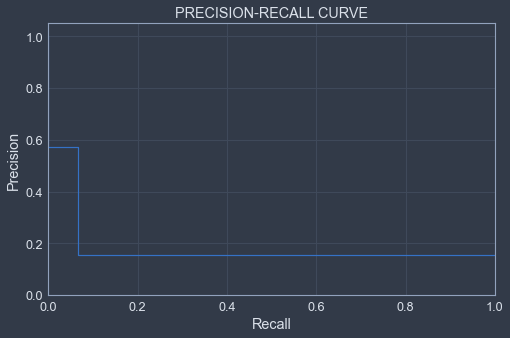

In [38]:
precision = dict()
recall = dict()
precision, recall, _ = precision_recall_curve(y_test, predictions)

plt.figure(figsize=(8,5))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('PRECISION-RECALL CURVE')
plt.show()

**CONCLUSION**

The imbalance of the dataset needs to be taken into account to try and improve the current model performance.

___
## Model 2 - Dataset imbalance accounted for
**In this section, we will use cross-validation combined with the Synthetic Minority Over-sampling Technique (SMOTE) to better account for the imbalance of the dataset.**
### Input/Output definition

In [39]:
X = df.drop('TenYearCHD', axis=1)
y = df['TenYearCHD']

### Train/Test split
**Instead of using the usual train_test_split function from SciKit.Learn, we will use the StratifiedKFold method.**
This cross-validation technique is a variation of KFold that returns stratified folds. The folds are made by preserving the percentage of samples for each class.

In [40]:
skf = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_idx, test_idx in skf.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

**Compare original label distribution to train/test split label distribution.**

In [41]:
_, original_labels_count = np.unique(y, return_counts=True)
original_dist = np.round(original_labels_count/len(y)*100, 2)
_, train_labels_count = np.unique(y_train, return_counts=True)
train_dist = np.round(train_labels_count/len(y_train)*100, 2)
_, test_labels_count = np.unique(y_test, return_counts=True)
test_dist = np.round(test_labels_count/len(y_test)*100, 2)

print('LABELS DISTRIBUTION')
print('\tOriginal:\t\t', original_dist[0], '% (label 0)\t', original_dist[1], '% (label 1)')
print('\tTraining set:\t\t', train_dist[0], '% (label 0)\t', train_dist[1], '% (label 1)')
print('\tTest set:\t\t', test_dist[0], '% (label 0)\t', test_dist[1], '% (label 1)')

LABELS DISTRIBUTION
	Original:		 85.08 % (label 0)	 14.92 % (label 1)
	Training set:		 85.09 % (label 0)	 14.91 % (label 1)
	Test set:		 85.07 % (label 0)	 14.93 % (label 1)


### Data scaling

In [42]:
scaler = MinMaxScaler()

scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_train, y_test = y_train.values, y_test.values

### Define and fit model to training data
**First, we need to define a grid of parameters that will be used during cross-validation.**

In [43]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [1,0.1,0.01,0.001,0.0001],
              'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}

**Next, we will define an instance of RandomizedSearchCV using SVC as the estimator.**

In contrast to GridSearchCV, not all parameter values are tried out, but rather a fixed number of parameter settings is sampled from the specified distributions. The number of parameter settings that are tried is given by n_iter. This will allow the training to be a little more efficient.

In [44]:
randomized_SVC = RandomizedSearchCV(SVC(), param_grid, n_iter=4)

**Now, we will create a loop that will iterate through each fold generated by the StratifiedKFold method and create a pipeline that will apply the SMOTE method to the dataset and run our defined classifier.**

_Note: a variety of evaluation scores will be saved throughout the process._

In [45]:
accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []
auc_lst = []

for train, test in skf.split(X_train_scaled, y_train):
    pipeline = make_pipeline(SMOTE(sampling_strategy='minority'), randomized_SVC)
    model = pipeline.fit(X_train_scaled[train], y_train[train])
    best_model = randomized_SVC.best_estimator_
    predictions = best_model.predict(X_train_scaled[test])    

    accuracy_lst.append(pipeline.score(X_train_scaled[test], y_train[test]))
    precision_lst.append(precision_score(y_train[test], predictions))
    recall_lst.append(recall_score(y_train[test], predictions))
    f1_lst.append(f1_score(y_train[test], predictions))
    auc_lst.append(roc_auc_score(y_train[test], predictions))

### Model evaluation
**First, let's print the mean evaluation scores.**

In [46]:
print('MODEL EVALUATION')
print('\tMean accuracy:\t',  np.round(np.mean(accuracy_lst), 2))
print('\tMean precision:\t', np.round(np.mean(precision_lst), 2))
print('\tMean recall:\t', np.round(np.mean(recall_lst), 2))
print('\tMean f1-score:\t', np.round(np.mean(f1_lst), 2))

MODEL EVALUATION
	Mean accuracy:	 0.67
	Mean precision:	 0.24
	Mean recall:	 0.57
	Mean f1-score:	 0.34


**Then, we will generate predictions using the best model generated during cross-validation:**

In [47]:
predictions = best_model.predict(X_test_scaled)

**Evaluate the model using classification report and confusion matrix:**

In [48]:
cm = confusion_matrix(y_test, predictions)
print('CONFUSION MATRIX\n')
print('Total number of')
print('\tTrue positives:\t\t', cm[1,1])
print('\tTrue negatives:\t\t', cm[0,0])
print('\tFalse positives:\t', cm[0,1], '\t\tType I error')
print('\tFalse negatives:\t', cm[1,0], '\t\tType II error')
print('\n')
print('Correct classifications:\t', np.round(100*(cm[0,0]+cm[1,1])/len(X_test),2), '%')
print('Incorrect classifications:\t', np.round(100*(cm[1,0]+cm[0,1])/len(X_test),2), '%')
print('\nCLASSIFICATION REPORT\n')
print(classification_report(y_test, predictions))

CONFUSION MATRIX

Total number of
	True positives:		 95
	True negatives:		 426
	False positives:	 252 		Type I error
	False negatives:	 24 		Type II error


Correct classifications:	 65.37 %
Incorrect classifications:	 34.63 %

CLASSIFICATION REPORT

              precision    recall  f1-score   support

           0       0.95      0.63      0.76       678
           1       0.27      0.80      0.41       119

    accuracy                           0.65       797
   macro avg       0.61      0.71      0.58       797
weighted avg       0.85      0.65      0.70       797



**Finally, we can also look at the average precision-recall score and precision-recall curve:**

In [49]:
average_precision = average_precision_score(y_test, predictions)

print('Average precision-recall score: {0:0.2f}'.format(average_precision))

Average precision-recall score: 0.25


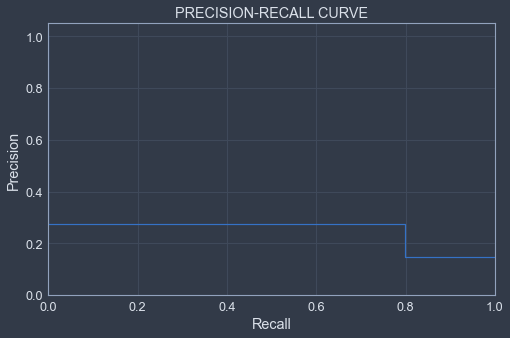

In [50]:
precision = dict()
recall = dict()
precision, recall, _ = precision_recall_curve(y_test, predictions)

plt.figure(figsize=(8,5))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('PRECISION-RECALL CURVE')
plt.show()

___
## Conclusion

The performance of the model was improved after accounting for the original imbalance of the dataset. More specifically, the recall score on the under-represented label was largly improved after the combined implementation of the SMOTE and cross-validation methods. We also significantly reduced the number of False Negatives and increased the number of False Positives, which is largly preferable compared to the outcome of the first model.

The overall precision of the model could still be improved, either by increasing the size of the dataset, or by testing other classification approaches (e.g. Logistic Regression, Artificial Neural Network).

**This pipeline could easily be transferred to other support vector machine classification problems.**